# News Popularity

In this notebook, we will:
* Use the UCI news dataset which has a popularity score
* Use Word2Vec to create word embeddings, and visualize word clusters on a t-SNE plot
* Do the same with titles, by averaging the word vectors in each title
* Train a model based on title embedding, topic, time since publishing, and sentiment, in order to predict the article's popularity on each platform

In [3]:
!pip install  xgboost

  Using cached https://files.pythonhosted.org/packages/5e/49/b95c037b717b4ceadc76b6e164603471225c27052d1611d5a2e832757945/xgboost-0.90-py2.py3-none-win_amd64.whl


In [13]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nisharat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nisharat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [27]:
main_data = pd.read_csv('dataset/News_Final.csv')

In [28]:
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


# Data Preprossesing

We'll start by doing some cleaning and manipulation on the text data.

In [29]:
article_titles = main_data['Title']
article_titles.shape

(93239,)

In [30]:
# Collapse the list of strings into a single long string for processing
titles_list = [title for title in article_titles]
big_title_string = ' '.join(titles_list)

# Tokenize the string into words
tokens = word_tokenize(big_title_string)
words = [word.lower() for word in tokens if word.isalpha()]

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

words[10:20]

['nouriel',
 'roubini',
 'global',
 'economy',
 'back',
 'finland',
 'gdp',
 'expands',
 'tourism',
 'govt']

In [31]:
# Load Word2Vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin', binary = True) 
model.vector_size

300

What a word vector looks like:

In [32]:
const_vec = model['constitution']
const_vec[:20] # First 20 components

array([-0.07617188,  0.0279541 ,  0.2734375 ,  0.3203125 , -0.09521484,
       -0.3359375 ,  0.10351562, -0.06494141,  0.18652344,  0.06347656,
       -0.1171875 , -0.07128906, -0.1796875 ,  0.2578125 , -0.12353516,
        0.14746094, -0.05517578,  0.21679688, -0.05566406, -0.40820312],
      dtype=float32)

In [33]:
# creating a dataframe of embeddings for each word
vector_list = [model[word] for word in words if word in model.vocab]
words_filtered = [word for word in words if word in model.vocab]
word_vec_zip = zip(words_filtered, vector_list)
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(21805, 300)

Now we have a bunch of tidy vectors in a DataFrame. Each column is the word's component for that dimension (300 dimensions total).

In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
obama,-0.123535,0.072266,0.171875,0.402344,-0.125977,-0.302734,-0.044922,-0.015259,0.171875,-0.043457,...,-0.055420,-0.138672,-0.064453,-0.104004,-0.267578,-0.205078,-0.111816,-0.022461,0.066895,0.026855
lays,-0.052246,-0.057373,0.193359,-0.106934,0.298828,-0.166016,0.137695,0.125000,-0.032227,-0.096191,...,-0.172852,-0.484375,-0.228516,0.168945,-0.291016,0.003647,0.041016,0.229492,0.248047,0.353516
wreath,0.166992,0.199219,-0.082031,0.142578,0.055420,-0.102539,0.103516,-0.138672,0.030884,-0.007050,...,0.015503,-0.085938,-0.173828,0.109863,0.096680,-0.102051,0.119629,-0.287109,-0.085938,0.188477
arlington,-0.006653,0.023926,0.141602,0.160156,0.052490,0.113281,-0.125000,-0.138672,-0.136719,0.023071,...,0.130859,0.104004,0.064453,0.068848,-0.069336,-0.137695,-0.000572,-0.125977,-0.086914,0.112793
national,-0.135742,0.175781,0.117188,0.078613,0.052490,-0.238281,0.092773,-0.083984,0.061523,-0.062500,...,0.034180,-0.039551,0.034424,-0.075195,0.006775,-0.110840,0.069336,-0.068359,0.032471,-0.009338


# Viz: t-SNE

In [35]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 500 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:500])

Now we're ready to plot our reduced array of word vectors and see what patterns we can find.

In [36]:
# print most similar words to query_words
query_words = ['girl', 'snoop', 'love', 'yeah', 'oh']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


|     girl      ||     snoop     ||     love      ||     yeah      ||      oh       |
|      boy      ||   snooping    ||     loved     ||     Yeah      ||      Oh       |
| teenage_girl  ||    snoops     ||     adore     ||      hey      ||      hey      |
|     woman     ||   eavesdrop   ||     loves     ||     kinda     ||      uh       |
|   teenager    ||    snooped    ||    passion    ||     geez      ||      Uh       |
|  schoolgirl   ||   snoopers    ||     hate      ||     maybe     ||      Ahh      |
| teenaged_girl || eavesdropping ||    loving     ||    Oh_yeah    ||     gawd      |
|   daughter    ||   Snooping    ||     Ilove     || Oh_yeah_yeah  ||     ohhh      |
|    mother     ||    surveil    ||   affection   ||   Yeah_yeah   ||      Ah       |
|    toddler    ||    snooper    || undying_love  ||     guess     ||      Ugh      |
|     girls     ||    spying     ||absolutely_adore||     dunno     ||     Gawd      |


In [37]:
# print most similar words to query_words
query_words = ['google','facebook', 'Democrat','Republican', 'UN']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


|    google     ||   facebook    ||   Democrat    ||  Republican   ||      UN       |
|  google.com   ||   Facebook    ||  Republican   ||      GOP      ||United_Nations |
| google_yahoo  ||   FaceBook    ||  Democratic   ||  Democratic   ||     U.N.      |
|   wikipedia   ||    twitter    ||   Demo_crat   ||   Democrat    ||  UN_Security  |
|www.google.com ||    myspace    ||   Democrats   ||  Republicans  ||Untied_Nations |
|    googled    ||    Twitter    ||      GOP      ||   Democrats   ||   UN_envoy    |
|   googling    ||twitter_facebook||    senator    ||  Re_publican  ||UN_peacekeeping|
|   slashdot    || Facebook.com  ||  congressman  ||  Repub_lican  ||Security_Council|
|  lifehacker   ||myspace_facebook||     Sen.      ||   Repubican   ||     Annan     |
|    gizmodo    ||facebook_twitter||  Republicans  ||   Republian   ||      UNs      |
|     inurl     ||   linkedin    ||   democrat    || Repub_licans  ||  Kofi_Annan   |


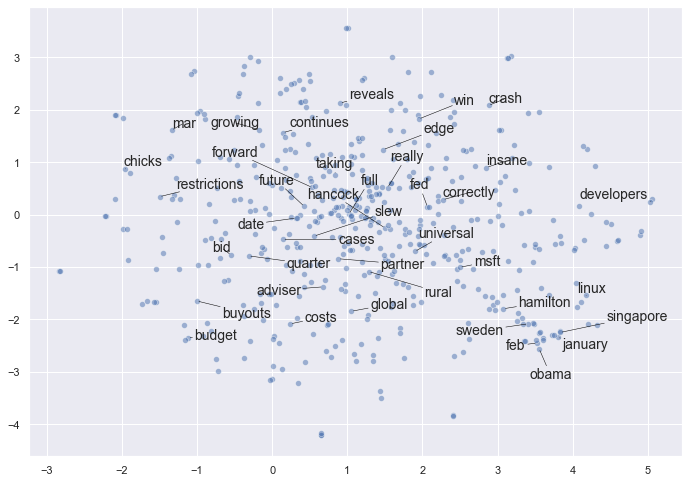

In [40]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10)) #plot a few words not all

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Note that if we were to run the t-SNE again with different parameters, we may observe some similarities to this result, but we're not guaranteed to see the exact same patterns. t-SNE, as compared to PCA, is not deterministic. Relatedly, tightness of clusters and distances between clusters are not always meaningful. It is meant primarily as an exploratory tool, rather than as a decisive indicator of similarity. 

# Sentence Embeddings? 

Doc2Vec is quite slow, I've used mean of word embeddings that occur in a sentence!

In [41]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [42]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

37 docs removed
0 docs removed


In [43]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

# t-SNE for Document Vectors

In [44]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:1000])

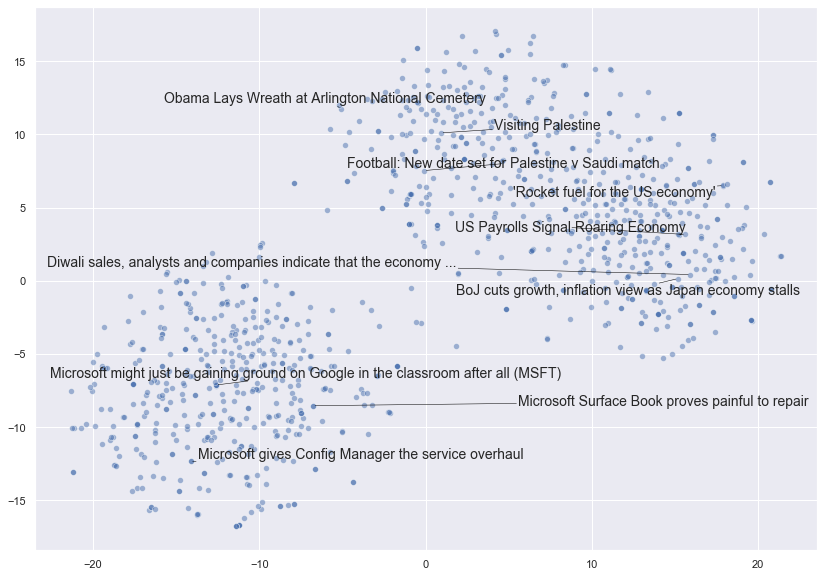

In [45]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 1000, 100)) #

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Pretty interesting! We can see that the t-SNE has collapsed the document vectors into a dimensional space where the documents are spread out based on whether their content has more to do with countries, world leaders, and foreign affairs, or has more to do with technology companies. 

In [46]:
# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = main_data.drop(main_data[(main_data.Facebook == -1) | 
                                     (main_data.GooglePlus == -1) | 
                                     (main_data.LinkedIn == -1)].index)

# Also drop all rows where we don't know the source
main_data = main_data.drop(main_data[main_data['Source'].isna()].index)

main_data.shape

(81417, 11)

# How popular are news articles?

The popularity can be determined by number of shares on Facebook, GooglePlus and Linkedin. 

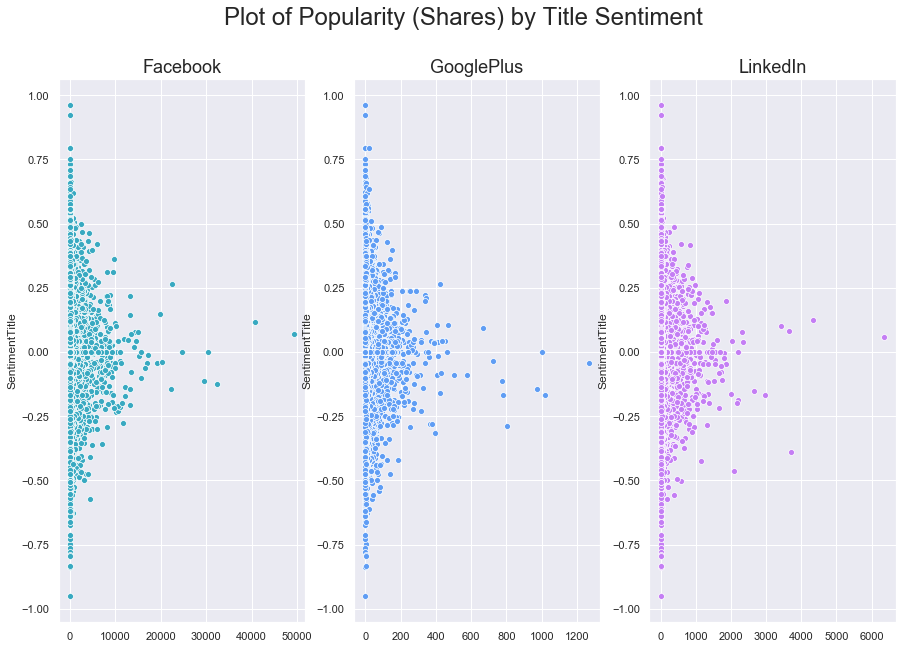

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

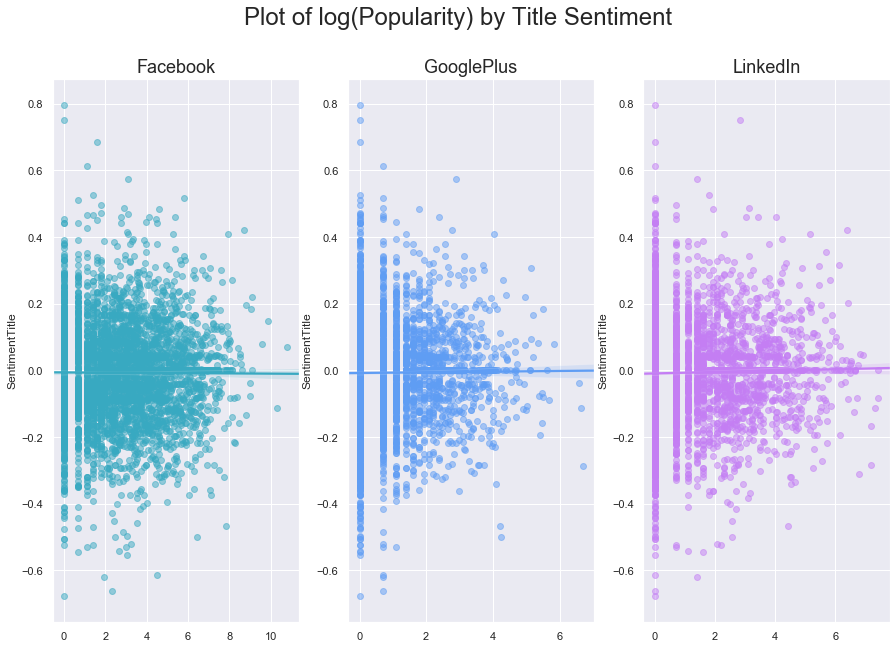

In [48]:
# Our data has over 80,000 rows, so let's subsample it to make the log-transformed scatterplot easier to read

subsample = main_data.sample(5000)

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
    # Regression plot, so we can gauge the linear relationship
    sns.regplot(x = np.log(subsample[platform] + 1), y = subsample['SentimentTitle'], 
                ax=subplot, 
                color=color,
                # Pass an alpha value to regplot's scatterplot call
                scatter_kws={'alpha':0.5})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of log(Popularity) by Title Sentiment', fontsize=24)

plt.show()

# Can the titles help predict popularity?

Our exploratory visualizations may not have yielded much to work from, but we can still see if there are any non-visual patterns we've missed that a model might discover. Our first task in preparing the data for modeling is to rejoin the document vectors with their respective titles. Thankfully, when we were preprocessing the corpus, we processed the `corpus` and `titles_list` simultaneously, so the vectors and the titles they represent will still match up. Meanwhile, in `main_df`, we have dropped all of the articles that had -1 popularity, so we'll need to drop the vectors that represent those article titles.

Training a model on these enormous vectors as-is will not be possible on this computer, but we'll see what we can do with a little dimension reduction.

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, random_state=10)

# x is the array with our 300-dimensional vectors
reduced_vecs = pca.fit_transform(x)

We will be using these document vectors as features in predicting popularity.

In [54]:
df_w_vectors = pd.DataFrame(reduced_vecs)
df_w_vectors['Title'] = titles_list
main_w_vectors = pd.concat((df_w_vectors, main_data), axis=1)
# Get rid of vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)
main_w_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
726,0.610009,-0.378075,-0.134921,0.009630,0.104041,0.144502,-0.154376,-0.164918,0.007274,-0.028512,...,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0.0,0.0,0.0
727,-0.540840,-0.411312,-0.179411,-0.234008,0.080068,-0.047119,-0.128647,-0.044599,-0.006016,-0.173711,...,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0.0,0.0,0.0
728,-0.540840,-0.411312,-0.179411,-0.234008,0.080068,-0.047119,-0.128647,-0.044599,-0.006016,-0.173711,...,Economy to improve though no change in last 6 ...,"New Delhi, Nov 8 (IANS) Majority of Indian bus...",IANS via Yahoo Maktoob News,economy,2015-11-08 05:48:00,-0.082022,0.186968,0.0,0.0,0.0
729,0.497476,-0.475604,-0.159985,-0.162602,0.012534,0.077912,-0.078580,-0.061363,-0.139491,0.058723,...,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0.0,0.0,0.0
730,-0.160366,-0.275578,0.342931,0.120123,0.155041,0.243502,0.174798,0.224570,-0.021191,0.018534,...,IDC predicts the emergence of ‘DX economy’,KUCHING: The global digital economy is about t...,The Borneo Post,economy,2015-11-08 08:34:00,0.000000,0.003189,1.0,0.0,0.0


In [56]:
# Drop all non-numeric, non-dummy columns, for feeding into the models
cols_to_drop = ['Title', 'Headline', 'PublishDate', 'Source'] 

data_only_df = pd.get_dummies(main_w_vectors, columns = ['Topic']).drop(columns=cols_to_drop)

"""
# Standardize DaysSinceEpoch since the raw numbers are larger in magnitude 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Reshape so we can feed the column to the scaler
standardized_days = np.array(data_only_df['DaysSinceEpoch']).reshape(-1, 1)
data_only_df['StandardizedDays'] = scaler.fit_transform(standardized_days)

# Drop the raw column; we don't need it anymore
data_only_df.drop(columns=['DaysSinceEpoch'], inplace=True)

# Look at the new range
data_only_df['StandardizedDays'].describe()
"""


"\n# Standardize DaysSinceEpoch since the raw numbers are larger in magnitude \nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\n\n# Reshape so we can feed the column to the scaler\nstandardized_days = np.array(data_only_df['DaysSinceEpoch']).reshape(-1, 1)\ndata_only_df['StandardizedDays'] = scaler.fit_transform(standardized_days)\n\n# Drop the raw column; we don't need it anymore\ndata_only_df.drop(columns=['DaysSinceEpoch'], inplace=True)\n\n# Look at the new range\ndata_only_df['StandardizedDays'].describe()\n"

In [57]:
# Create individual DataFrames for each platform's regression task
fb_data_only_df = data_only_df.drop(columns=['GooglePlus', 'LinkedIn'])
goog_data_only_df = data_only_df.drop(columns=['Facebook', 'LinkedIn'])
li_data_only_df = data_only_df.drop(columns=['Facebook', 'GooglePlus'])

# Facebook Popularity: First Attempt

In [58]:
X = fb_data_only_df.drop('Facebook', axis=1)
y = fb_data_only_df['Facebook']

# 80% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [59]:
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)
# Fit the classifier to the training set
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

E:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:39:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


355900.7801207552

Underwhelming results - let's do some hyperparameter tuning and see if we can improve. Hyperparameter grid repurposed from [this Kaggle article.](https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv)

In [60]:
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  1.1min finished
E:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.012993170735543125
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [61]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Nope not good!

314983.7228420219

As seen above, the data in its current state seems insufficient for this model to perform. Let's see if we can improve it with a little feature engineering: we'll train some classifiers to separate the two main groups of articles: Duds (0 or 1 share) vs. Not Duds. 

The idea is that if we can give the regressor a feature (the probability that the article will have extremely low shares), it may perform more favorably on predicting the more highly-shared articles, thus lowering the residual values for those articles and reducing mean squared error.

# Classification: Detect Dud Articles

Let's take a look at the distribution of FB popularity as a whole:

In [62]:
fb_data_only_df['Facebook'].describe()

count    81398.000000
mean       129.739932
std        662.114843
min          0.000000
25%          1.000000
50%          8.000000
75%         44.000000
max      49211.000000
Name: Facebook, dtype: float64

This tells us that 25% of articles don't even get one share. Also, from the log-transformed plots we made earlier, we can note that in general, there are 2 chunks of articles: 1 cluster at 0, and another cluster (the long tail) going from 1 onwards. We can train a few classifiers to identify whether the article will be a "dud" (be in the 0 shares bin), and then use the predictions of those models as features for the final regressor, which will predict probability. This is called **model stacking**.

In [63]:
# Define a quick function that will return 1 (true) if the article has 0-1 share(s)
def dud_finder(popularity):
    if popularity <= 1:
        return 1
    else:
        return 0

# Create target column using the function
fb_data_only_df['is_dud'] = fb_data_only_df['Facebook'].apply(dud_finder)
fb_data_only_df[['Facebook', 'is_dud']].head()

,Facebook,is_dud
726,0.0,1
727,0.0,1
728,0.0,1
729,0.0,1
730,1.0,1


In [64]:
fb_data_only_df['is_dud'].value_counts()

0    58352
1    23046
Name: is_dud, dtype: int64

In [65]:
# 28% of articles can be classified as "duds"
fb_data_only_df['is_dud'].sum() / len(fb_data_only_df)

0.2831273495663284

Now that we have our dud feature made, we'll initialize the classifiers. We'll use a Random Forest, an optimized XGBClassifier, and a K-Nearest Neighbors classifier. First, the XGB, since it requires a lot of fiddling.

In [66]:
X = fb_data_only_df.drop('is_dud', axis=1)
y = fb_data_only_df['is_dud']

# 80% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [67]:
# Hyper-parameters to tune
xgc = xgb.XGBClassifier()
parameters = {'nthread':[4],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb_grid = GridSearchCV(xgc,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   22.6s finished


1.0
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'silent': 1, 'subsample': 0.7}


In [68]:
# Give it 200 estimators, 100 is just a restriction to make the grid search run faster
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 200, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgc = xgb.XGBClassifier(random_state=10, **params)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = fb_data_only_df.drop(['is_dud', 'Facebook'], axis=1)
y = fb_data_only_df['is_dud']

# 70% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=10)
#xgc = xgb.XGBClassifier(random_state=10)
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
knn = KNeighborsClassifier()

preds = {}
for model_name, model in zip(['XGClassifier', 'RandomForestClassifier', 'KNearestNeighbors'], [xgc, rfc, knn]):
    model.fit(X_train, y_train)
    preds[model_name] = model.predict(X_test)

In [70]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

for k in preds:
    print("{} performance:".format(k))
    print()
    print(classification_report(y_test, preds[k]), sep='\n')

XGClassifier performance:

              precision    recall  f1-score   support

           0       0.72      1.00      0.84     11694
           1       0.43      0.00      0.00      4586

    accuracy                           0.72     16280
   macro avg       0.57      0.50      0.42     16280
weighted avg       0.64      0.72      0.60     16280

RandomForestClassifier performance:

              precision    recall  f1-score   support

           0       0.72      0.97      0.83     11694
           1       0.41      0.05      0.09      4586

    accuracy                           0.71     16280
   macro avg       0.56      0.51      0.46     16280
weighted avg       0.63      0.71      0.62     16280

KNearestNeighbors performance:

              precision    recall  f1-score   support

           0       0.73      0.85      0.79     11694
           1       0.35      0.20      0.26      4586

    accuracy                           0.67     16280
   macro avg       0.54      0.5

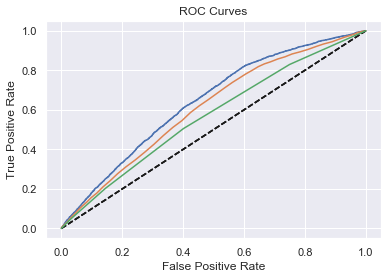

In [71]:
# Plot ROC curves
for model in [xgc, rfc, knn]:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

# Facebook Popularity: Round 2

In [72]:
# Now we can add the averaged probabilities that each article is a dud to help out the regressor
averaged_probs = (xgc.predict_proba(X)[:, 1] +
                  knn.predict_proba(X)[:, 1] + 
                  rfc.predict_proba(X)[:, 1]) / 3

In [73]:
X['prob_dud'] = averaged_probs
y = fb_data_only_df['Facebook']

# Reinitialize the train_test_split since we've changed back to regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Another round of hyperparameter tuning
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, .05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:  1.1min finished
E:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.029219525360802804
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [74]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=250,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [75]:
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Oops...the performance is essentially the same as it was before any model stacking.

313450.03715111123

In [76]:
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.03426413610577583
Model weight for feature 1: 0.022774551063776016
Model weight for feature 2: 0.03819835186004639
Model weight for feature 3: 0.04564061015844345
Model weight for feature 4: 0.02656041644513607
Model weight for feature 5: 0.054494425654411316
Model weight for feature 6: 0.04494691267609596
Model weight for feature 7: 0.035776250064373016
Model weight for feature 8: 0.04061907157301903
Model weight for feature 9: 0.05437180772423744
Model weight for feature 10: 0.09040302038192749
Model weight for feature 11: 0.049712687730789185
Model weight for feature 12: 0.025626730173826218
Model weight for feature 13: 0.054229963570833206
Model weight for feature 14: 0.0715377926826477
Model weight for feature IDLink: 0.050490617752075195
Model weight for feature SentimentTitle: 0.023670516908168793
Model weight for feature SentimentHeadline: 0.047653231769800186
Model weight for feature Topic_economy: 0.008145837113261223
Model weight for feature Top

We can at least claim one victory: the model thought that `prob_dud` was the most important feature! 